# Analize *in vitro* PAM data

In [3]:
import numpy as np
import pandas as pd
import gzip
from collections import Counter
from Bio.Seq import Seq
from Bio import SeqIO
import itertools
import matplotlib.pyplot as plt
import logomaker
import matplotlib
from matplotlib import rcParams
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.colors import ListedColormap
%matplotlib notebook

In [4]:
variant_file = 'PrCas9_S2_L001_R1_001.fastq.gz'

In [5]:
variant_name = 'PrCas9'

In [6]:
with gzip.open(variant_file, 'rt') as fin:
    variant_seqs = [record for record in SeqIO.parse(fin, 'fastq')]

In [8]:
seq_before_pam = 'CTGCTGAACCGCTCTTCCGATCTCCT'
seq_after_pam = 'GCGCAGGTCACGAGGCATGCAAGCTTGGCTGTTTTG'

In [9]:
pos_start = [str(rec.seq).find(seq_before_pam[-15:-5]) for rec in variant_seqs]

In [11]:
pos_end = [str(rec.seq).find(seq_after_pam[0:10]) for rec in variant_seqs]

In [13]:
complete = [pos_end[i]!=-1 and pos_start[i]!=-1 for i in range(len(pos_end))]

In [15]:
complete_pos = [pos_end[i]-pos_start[i]-len(seq_before_pam[-15:-5]) for i in range(len(complete)) if complete[i]]

In [17]:
complete_len = [pos_end[i]-pos_start[i] == len(seq_before_pam[-15:-5])+13 for i in range(len(pos_end))]

In [19]:
pams = [str(variant_seqs[i].seq)[pos_end[i]-8:pos_end[i]] for i in range(len(complete_len)) if complete_len[i]]

In [20]:
pams = [pam for pam in pams if 'N' not in pam]

## Sequence logo

In [22]:
def make_freq_df(seqs):
    counters = [Counter() for i in range(len(seqs[0]))]
    for i in range(len(counters)):
        for seq in seqs:
            counters[i][seq[i]] +=1
    freqs = pd.DataFrame(counters).fillna(0)
    freqs = freqs.divide(freqs.sum(axis=1), axis=0)
    return freqs

<IPython.core.display.Javascript object>


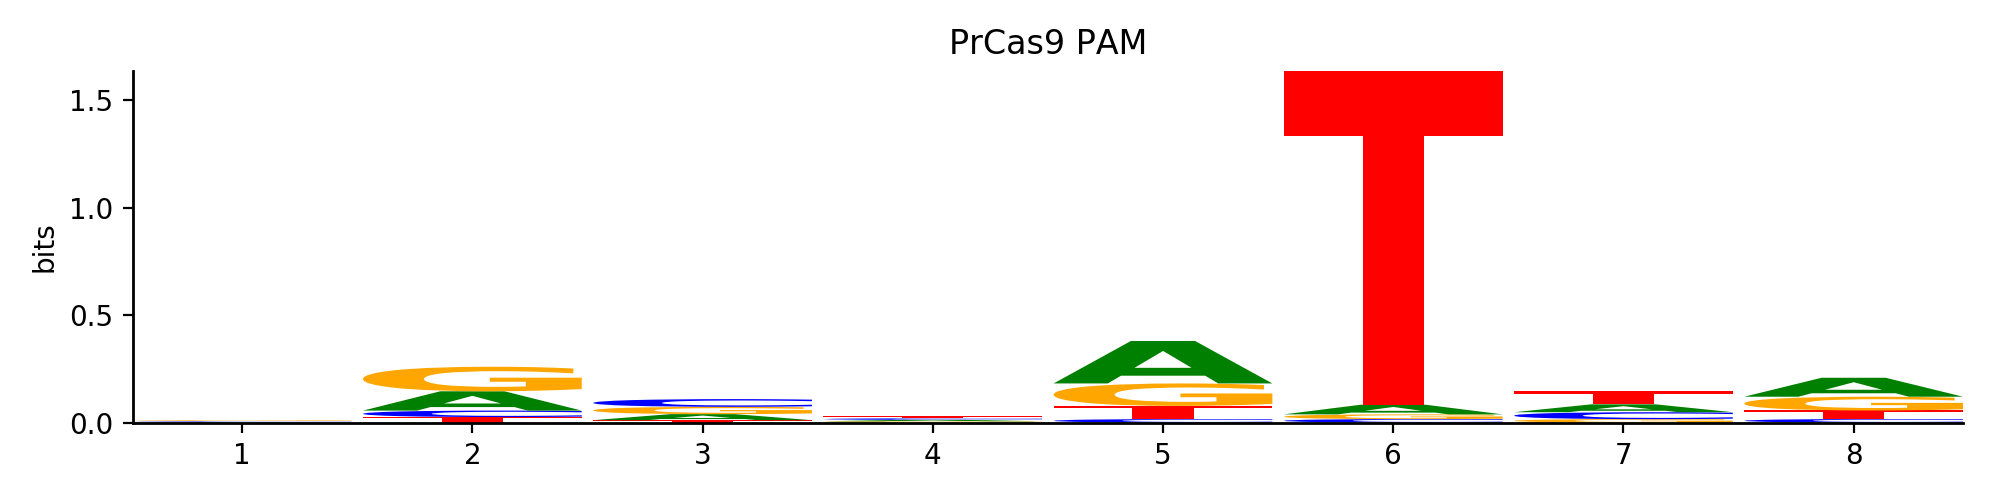

In [23]:
# compute frequencies
seq_freqs = make_freq_df(pams)

# create Logo object
seq_info = logomaker.transform_matrix(seq_freqs, from_type='probability',
                                       to_type='information')
seq_logo = logomaker.Logo(seq_info)

# style using Logo methods
seq_logo.style_spines(visible=False)
seq_logo.style_spines(spines=['left', 'bottom'], visible=True)
seq_logo.style_xticks(fmt='%d', anchor=0)
seq_logo.ax.set_xticklabels(np.arange(1,9))

# style using Axes methods
seq_logo.ax.set_ylabel("bits")
plt.title(variant_name + ' PAM')
plt.tight_layout()
plt.show()

## PAM heatmap

In [24]:
pam_counts = Counter(pams)

In [25]:
counts_df = pd.DataFrame.from_dict(dict(pam_counts), columns=['Count'], orient='index')

In [26]:
# get missing sequences
missing_seqs = [''.join(seq) for seq in itertools.product(['A','G','T','C'],
    repeat=8) if ''.join(seq) not in counts_df.index]

In [27]:
missing_seqs_df = pd.DataFrame({'Count':[0]*len(missing_seqs)}, index=missing_seqs)
counts_df_full = pd.concat([counts_df, missing_seqs_df])

In [28]:
# pseudocounts
pseudocount = 1
counts_df_full['Count'] = counts_df_full['Count'].add(pseudocount)

In [35]:
def all_PAM_frequencies(library):
    """
    Given a library of random sequence counts, returns frequencies for all possible PAMs
    """
    pam_len = len(library.index[0])
    all_pams = [''.join(x) for x in itertools.product(['A','G','T','C','N'], repeat=pam_len)]
    # make pam dictionary
    pam_dictionary = {}
    for pam in all_pams:
        nN = pam.count('N')
        if nN != 0 and nN != len(pam):
            pam_dictionary[pam] = [pam.replace('N', '{}').format(*it) for it in itertools.product(['A','G','T','C'], repeat=nN)]
            pam_dictionary[pam] = [pam for pam in pam_dictionary[pam] if pam in library.index]
    # make pam count dataframe list
    pam_counts_by_n_N = [library[['Count']]]
    # fill it
    for i in range(1,pam_len):
        # compute counts of PAMs with i Ns from counts of PAMs with i-1 Ns
        print('Computing counts for PAMs of length {}'.format(pam_len-i))
        all_pams_i_N = [pam for pam in all_pams if pam.count('N')==i]
        library_pam_i_N = {}
        for pam in all_pams_i_N:
            library_pam_i_N[pam] = library.loc[pam_dictionary[pam],'Count'].sum()
        pam_counts_by_n_N.append(pd.DataFrame.from_dict(library_pam_i_N, orient='index', columns=['Count']))
    # concatenate them and compute frequencies
    all_pams_df = [df.assign(Frequency=df['Count'].divide(library['Count'].sum()).values) for df in pam_counts_by_n_N]
    return all_pams_df

In [36]:
all_pams_df = all_PAM_frequencies(counts_df_full)

Computing counts for PAMs of length 7
Computing counts for PAMs of length 6
Computing counts for PAMs of length 5
Computing counts for PAMs of length 4
Computing counts for PAMs of length 3
Computing counts for PAMs of length 2
Computing counts for PAMs of length 1


In [37]:
all_pams_df_cc = pd.concat(all_pams_df)

In [32]:
base_dir = 'PAM/run_0/output/'
base_PAM_freqs = pd.read_csv(base_dir + 'base_library_PAM_frequencies.tsv', sep='\t',
                             index_col=0)

In [33]:
def compute_lrf(cut, base):
    lrf = {}
    pam_len = len(cut.index[0])
    
    for i in range(1,pam_len+1):
        pams = [indx for indx in cut.index if indx.count('N')==pam_len-i]
        lrf[i] = np.log10(cut.loc[pams, 'Frequency']/base.loc[pams, 'Frequency'])
        lrf[i] = lrf[i][np.isfinite(lrf[i])]
    return lrf

In [34]:
lrf = compute_lrf(all_pams_df_cc, base_PAM_freqs)

In [35]:
def make_PAM_array(pam_dfs, rowpos, colpos):
    '''
    colpos must come before rowpos
    '''
    n_specified_bases = len(rowpos)+len(colpos)
    data = pam_dfs[n_specified_bases].apply(lambda x: x if x > 0 else 0)
    array = []
    rowidx = [it for it in itertools.product(['A','G','T','C'], repeat=len(rowpos))]
    colidx = [it for it in itertools.product(['A','G','T','C'], repeat=len(colpos))]
    for ri in rowidx:
        new_row = []
        for ci in colidx:
            pam = ['N']*8
            for i in rowpos+colpos:
                pam[i] = '{}'
            pam = ''.join(pam).format(*ci, *ri)
            new_row.append(data[pam])
        array.append(new_row)
    return np.array(array), [''.join(i) for i in rowidx], [''.join(i) for i in colidx]  

In [36]:
def heatmap(data, row_labels, col_labels, colbarperc, xsize, ysize, lwd, ax=None,
            cbar_kw={}, cbarlabel="", **kwargs):

    if not ax:
        ax = plt.gca()

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="{}%".format(colbarperc), pad=0.05) #2
    plt.colorbar(im, cax=cax, **cbar_kw)

    # We want to show all ticks...
    ax.set_xticks(np.arange(data.shape[1]))
    ax.set_yticks(np.arange(data.shape[0]))
    # ... and label them with the respective list entries.
    ax.set_xticklabels(['\n'.join(list(l)) for l in col_labels])
    ax.set_yticklabels([' '.join(list(l)) for l in row_labels])

    # Let the horizontal axes labeling appear on top.
    ax.tick_params(top=True, bottom=False,
                   labeltop=True, labelbottom=False)

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), size=xsize, family='monospace') #3
    plt.setp(ax.get_yticklabels(), size=ysize, family='monospace') #2.5

    # Turn spines off and create white grid.
    for edge, spine in ax.spines.items():
        spine.set_visible(False)

    ax.set_xticks(np.arange(data.shape[1]+1)-.5, minor=True)
    ax.set_yticks(np.arange(data.shape[0]+1)-.5, minor=True)
    ax.grid(which="minor", color="w", linestyle='-', linewidth=lwd) # .2
    ax.tick_params(which="minor", bottom=False, left=False)

    return im

In [37]:
def make_PAM_heatmap(lrf, rowpos, colpos):
    heatmap_data, rowidx, colidx = make_PAM_array(lrf, rowpos, colpos)
    
    # get figsize, lbarperc, xsize, ysize, lwd
    ny = len(rowpos)
    nx = len(colpos)
    fgs = (6+nx, 6+ny)
    colbarperc = 3
    xsize_d = {'4':3, '3':6, '2':10, '1':10}
    ysize_d = {'4':2.5, '3':6, '2':10, '1':10}
    xsize = xsize_d[str(nx)]
    ysize = ysize_d[str(ny)]
    lwd = 13 / max(nx,ny)**3
    
    fig, ax = plt.subplots(figsize=fgs)
    im = heatmap(heatmap_data, rowidx, colidx, colbarperc, xsize, ysize, lwd,
                       ax=ax, cmap="Blues")
    fig.tight_layout()
    plt.show()

In [38]:
rowpos, colpos = [4,5], [1,2]

In [39]:
heatmap_data, rowidx, colidx = make_PAM_array(lrf, rowpos, colpos)

to_int = {'A':0, 'T':1, 'C':2, 'G':3}

to_base = {to_int[k]:k for k in to_int}

col_anno = pd.DataFrame([[to_int[i] for i in list(idx)] for idx in colidx]).transpose()

row_anno = pd.DataFrame([[to_int[i] for i in list(idx)] for idx in rowidx])

base_colormap = ListedColormap(["lightgreen", "tomato", "lightskyblue", "lemonchiffon"])

<IPython.core.display.Javascript object>


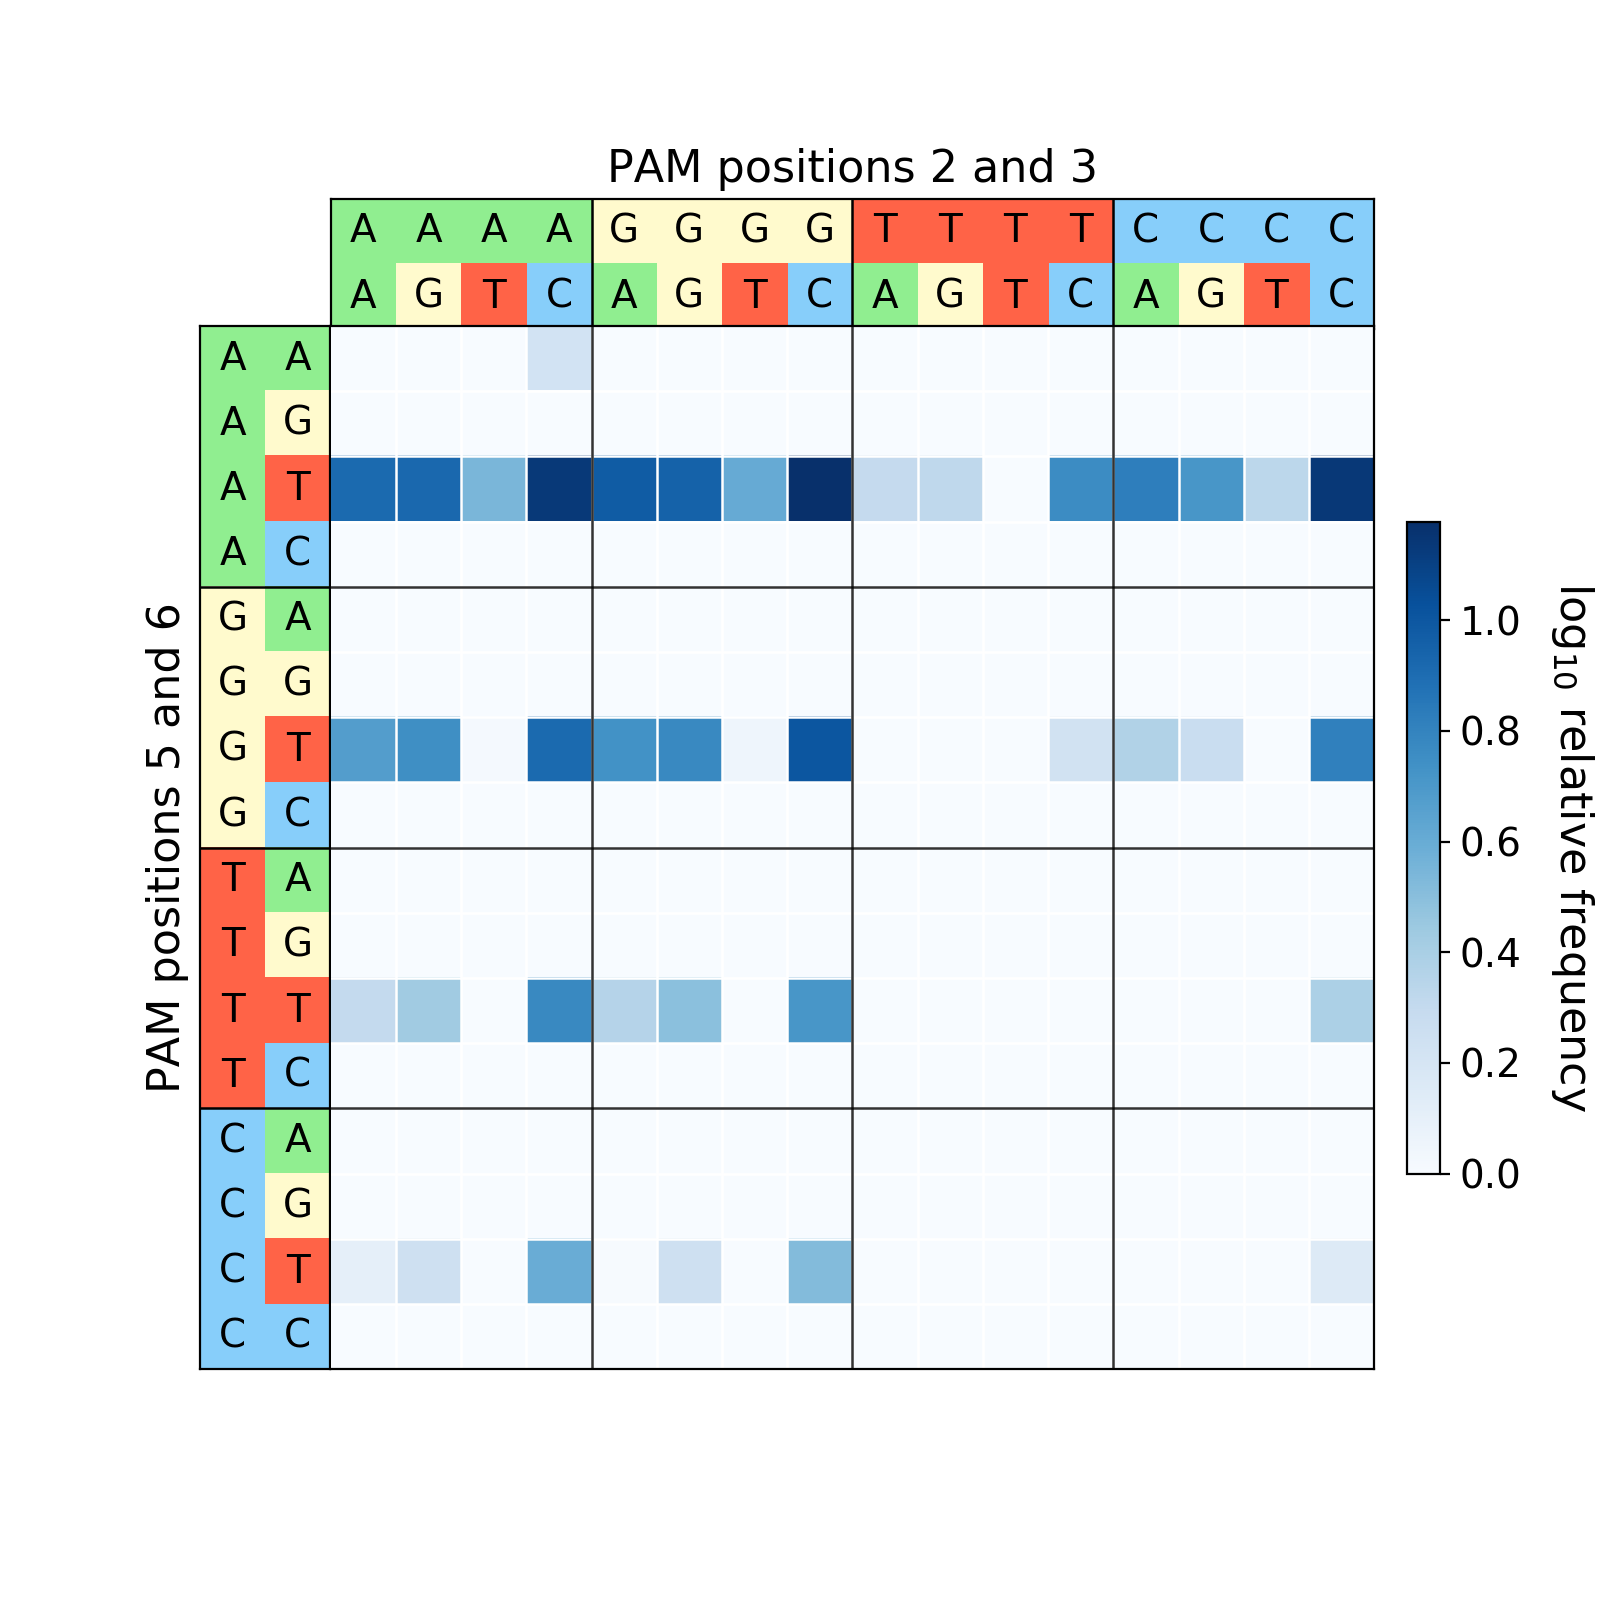

In [40]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(8, 8), gridspec_kw={
    'height_ratios': [2, 16], 'width_ratios': [2, 16, 0.5, 0.5]})

axes[0,0].axis('off')
axes[0,2].axis('off')
axes[0,3].axis('off')

ax=axes[0,1]
ax.imshow(col_anno, cmap=base_colormap)
ax.tick_params(bottom=False, labelleft=False, labelbottom=False, left=False)
ax.set_title('PAM positions {} and {}'.format(*np.array(colpos)+1), size=16)

for i in range(col_anno.shape[0]):
    for j in range(col_anno.shape[1]):
        text = ax.text(j, i, to_base[col_anno.loc[i, j]], size=14,
                       ha="center", va="center", color="k")

for i in np.arange(4,col_anno.shape[1]+1,4)-.5:
    ax.axvline(x=i, ls='-', color='k', zorder=3, linewidth=0.9)
        

ax=axes[1,0]
ax.imshow(row_anno, cmap=base_colormap)
ax.tick_params(bottom=False, labelleft=False, labelbottom=False, left=False)
ax.set_ylabel('PAM positions {} and {}'.format(*np.array(rowpos)+1), size=16)

for i in range(row_anno.shape[0]):
    for j in range(row_anno.shape[1]):
        text = ax.text(j, i, to_base[row_anno.loc[i, j]], size=14,
                       ha="center", va="center", color="k")

for i in np.arange(4,row_anno.shape[0]+1,4)-.5:
    ax.axhline(y=i, ls='-', color='k', zorder=3, linewidth=0.9)


ax=axes[1,1]
im = ax.imshow(heatmap_data, cmap="Blues")

ax.tick_params(bottom=False, labelleft=False, labelbottom=False, left=False)

axes[1,1].spines['left'].set_visible(False)

ax.set_xticks(np.arange(1,heatmap_data.shape[1]+1)-.5, minor=False)
ax.set_yticks(np.arange(1,heatmap_data.shape[0]+1)-.5, minor=False)
ax.grid(which="major", color="w", linestyle='-', linewidth=0.9)

for i in np.arange(4,heatmap_data.shape[1]+1,4)-.5:
    ax.axhline(y=i, ls='-', color='k', zorder=3, linewidth=0.9, alpha=0.8)
    ax.axvline(x=i, ls='-', color='k', zorder=3, linewidth=0.9, alpha=0.8)


ax.tick_params(which="minor", bottom=False, left=False)

ax=axes[1,2]
ax.set_aspect(16)
ax.axis('off')

ax=axes[1,3]
ax.set_aspect(20)
cbar = plt.colorbar(im, cax=ax)
cbar.ax.set_ylabel(r'log$_{10}$ relative frequency', size=16,
                   labelpad = 10, rotation=-90, va="bottom")
cbar.ax.tick_params(labelsize=14)



plt.subplots_adjust(hspace=-0.1, wspace=0.001)
plt.show()